# Present-day warming level identify

look at how different models warm (hot bias in cmip models, see when present-day warming level occurs to pick the 30-year period I will use) - output a csv with the central year / interval of the years to automatically feed this into the PR calculation script


created June 1 2023
rosa.pietroiusti@vub.be

In [3]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patches as mpatches

%matplotlib inline
import os, glob, re 
import math

# import my global variables and functions from other scripts
from settings import *
init()
print('loaded')

loaded


In [4]:
# import my global variables from other script
print(GCMs)

['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']


In [5]:
print(os.getcwd())

/vscmnt/brussel_pixiu_data/_data_brussel/104/vsc10419/scripts/attr-hw/attr-hw-scripts


In [6]:
# set-up paths 
data_path = os.path.join('..', '..', 'data', 'input-data')

# model GMST paths
gmst_paths_mod = os.path.join(data_path, 'gmst-models-isimip3b')
scenarios = ['historical','ssp370']

# observational dataset paths - not paramount, only for a comparison plot
gmst_paths_obs = os.path.join(data_path, 'gmst-obs') #download the different obs datasets here

# figures path
fig_path =  os.path.join('..','..', 'figures', 'fig-jun23-modeleval')
# Check if the directory exists
if not os.path.exists(fig_path):
    # If it doesn't exist, create it
    os.makedirs(fig_path)

# output path
out_path = os.path.join('..','..', 'data', 'modified-data', 'warming-models')
# Check if the directory exists
if not os.path.exists(out_path):
    # If it doesn't exist, create it
    os.makedirs(out_path)

In [7]:
# present-day warming, from Forster 2023

# ar6 method: observed anomaly wrt 1850-1900, using 10-year average leading up to today
# ar6 2010-2019: 1.06 (0.88 - 1.21) observed, 1.07 (0.8 - 1.3) anthropogenic
# updated to 2013-2022 in paper
# 1.15 (1 - 1.25) - observed
# 1.14 (0.9 - 1.4) - anthropogenic
warming_ar6_forster = 1.15 

#sr1.5 method updated: anthropogenic warming wrt 1850-1900, using 30-year period centered on today assuming current rate of warming continues
#sr1.5 2017: 1 (0.8-1.2)
#updated 2022 1.26 (1-1.6)
warming_sr15_forster = 1.26 




## To do: 
- find when models meet this level of warming, output year and feed it into the main analysis script (make a csv)
- plot different model warming paths
- extension: plot cfr. to some leading observational datasets since 1850 


## Functions 

In [8]:
# Automate this with utils and functions !!

# e.g. check_length


In [9]:
# Functions: calculate period of certain warming levels (potentially move to functions.py if I need to use this a lot)

def calc_warming_periods(gmst_df, windowsize, centered, target): 
    #gmst_df needs to be a dataframe with all the models as columns, values already as anomalies wrt 1850-1900
    
    gmst_roll = gmst_df.rolling(windowsize, min_periods=1, center=centered).mean() 
    
    df = gmst_roll
    val = target

    # make empty dataframe
    d = {'model': [], 'year': [],  'value': [], 'target': [], 'start_y': [], 'end_y': []}
    df_out = pd.DataFrame(data=d)

    for i, j in zip(df.columns.values, range(len(df.columns.values))):
        df_closest = df[i].iloc[(df[i]-val).abs().argsort()[:1]]
        
        if centered == False: # years leading up to closest (e.g., ar6)
            starty = df_closest.index.values[0]-(windowsize-1)
            endy = df_closest.index.values[0]
        elif centered == True: # years centered on closest (e.g., sr1.5)
            starty = df_closest.index.values[0]-int((windowsize/2-1))
            endy = df_closest.index.values[0]+int((windowsize/2)) # note - slightly skewed, this is ok ?
             
        df_mod = pd.Series({'model': i.replace('gmst_',''), 'year': df_closest.index.values[0], 'start_y': starty , 'end_y': endy,
                            'value': np.round(df_closest.values[0],4), 'target': val})
        df_out = pd.concat([df_out, df_mod.to_frame().T], ignore_index=True)
    
    return df_out

In [10]:
# unify historical and ssp370 1850-2100

def join_model_hist(GCM_list, gmst_paths_mod, scenarios, plot=False):

    for i in GCM_list:
        print(i)

        # concatenate hist to 2014 and ssp3-rcp70 from 2015
        gmst_paths = [glob.glob(os.path.join(gmst_paths_mod, scenarios[0], i, '*.txt'))[0], 
                      glob.glob(os.path.join(gmst_paths_mod, scenarios[1], i, '*.txt'))[0]]
        gmst_a = pd.read_csv(gmst_paths[0], delim_whitespace=True, comment='#', header=None, names=['year','gmst_{}'.format(i)], index_col=0)
        gmst_b = pd.read_csv(gmst_paths[1], delim_whitespace=True, comment='#', header=None, names=['year','gmst_{}'.format(i)], index_col=0)
        gmst_mod_raw = pd.concat([gmst_a, gmst_b])

        # as anomaly wrt 1850-1900
        baseline = gmst_mod_raw.loc[1850:1900].mean()
        gmst_mod = gmst_mod_raw - baseline
        
        if plot ==True: 
            # plot to check
            plt.plot(gmst_mod, label=i ) #gmst_mod.columns.values[0]
            plt.legend()
            plt.axhline(warming_ar6_forster, ls='--', c='black')
            plt.axhline(warming_sr15_forster, ls='--', c='gray')

        # make a single dataframe for easier and nicer plotting and analysis, just make sure not mixing up data! 
        if i == GCMs[0]:
            gmst_mod_all = gmst_mod
        else:
            gmst_mod_all = gmst_mod_all.merge(gmst_mod,left_index=True, right_index=True)
    
    return gmst_mod_all
    
    


## Step 1: Calculate ISIMIP3b model warming historical + ssp3-rcp70 wrt 1850-1900

Create timeseries of gmst anomaly wrt 1850-1900

CanESM5
CNRM-CM6-1
GFDL-ESM4
IPSL-CM6A-LR
MIROC6
MRI-ESM2-0


,gmst_CanESM5,gmst_CNRM-CM6-1,gmst_GFDL-ESM4,gmst_IPSL-CM6A-LR,gmst_MIROC6,gmst_MRI-ESM2-0
year,,,,,,
1850,0.096275,0.07598,-0.094941,-0.184196,-0.068196,0.062608
1851,-0.149725,0.03998,-0.151941,-0.016196,-0.095196,0.087608
1852,-0.101725,0.00998,0.027059,-0.032196,-0.079196,0.021608
1853,0.038275,0.03198,0.061059,0.036804,-0.019196,-0.052392
1854,-0.075725,0.03098,-0.113941,0.107804,0.191804,-0.107392
...,...,...,...,...,...,...
2096,6.090275,4.75998,3.465059,5.281804,3.370804,3.743608
2097,6.278275,4.75398,3.466059,5.512804,3.036804,3.795608
2098,6.364275,4.95798,3.442059,5.356804,3.112804,3.624608


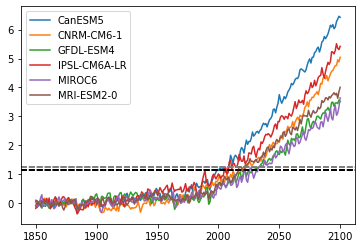

In [11]:
gmst_mod_all = join_model_hist(GCMs, gmst_paths_mod, scenarios, plot=True)
gmst_mod_all

## Step 2: find when models reach present-day level of warming

### 1. AR6 version updated in Forster 2023: 1.15 warming in 10-years leading up to today

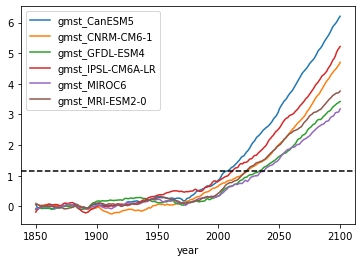

In [62]:

# ar6 def: 10-year period leading up to today (2022) = 1.15 warmer than 1850-1900

gmst_roll_ar6 = gmst_mod_all.rolling(10, min_periods=1, center=False).mean() 
gmst_roll_ar6.plot() 
plt.axhline(warming_ar6_forster, ls='--', c='black')

In [63]:
gmst_roll_ar6

,gmst_CanESM5,gmst_CNRM-CM6-1,gmst_GFDL-ESM4,gmst_IPSL-CM6A-LR,gmst_MIROC6,gmst_MRI-ESM2-0
year,,,,,,
1850,0.096275,0.07598,-0.094941,-0.184196,-0.068196,0.062608
1851,-0.026725,0.05798,-0.123441,-0.100196,-0.081696,0.075108
1852,-0.051725,0.04198,-0.073275,-0.077529,-0.080863,0.057275
1853,-0.029225,0.03948,-0.039691,-0.048946,-0.065446,0.029858
1854,-0.038525,0.03778,-0.054541,-0.017596,-0.013996,0.002408
...,...,...,...,...,...,...
2096,5.958975,4.46738,3.309159,4.905304,3.052004,3.673008
2097,6.010575,4.50828,3.344859,5.024004,3.069004,3.699708
2098,6.078475,4.57468,3.367759,5.104604,3.065904,3.698308


In [133]:
# find when it occurs in each model - develop function

df = gmst_roll_ar6
val = warming_ar6_forster # 2013-2022 value
print(val)

# make empty dataframe
d = {'model': [], 'year': [],  'value': [], 'target': [], 'start_y': [], 'end_y': []}
df_out = pd.DataFrame(data=d)

for i, j in zip(df.columns.values, range(len(df.columns.values))):
    df_closest = df[i].iloc[(df[i]-val).abs().argsort()[:1]]
    print(df_closest)
    df_mod = pd.Series({'model': i.replace('gmst_',''), 'year': df_closest.index.values[0], 'start_y': df_closest.index.values[0]-9, 'end_y': df_closest.index.values[0],
                        'value': np.round(df_closest.values[0],4), 'target': val})
    df_out = pd.concat([df_out, df_mod.to_frame().T], ignore_index=True)

1.15
year
2007    1.155275
Name: gmst_CanESM5, dtype: float64
year
2024    1.16068
Name: gmst_CNRM-CM6-1, dtype: float64
year
2034    1.160159
Name: gmst_GFDL-ESM4, dtype: float64
year
2011    1.129504
Name: gmst_IPSL-CM6A-LR, dtype: float64
year
2037    1.144204
Name: gmst_MIROC6, dtype: float64
year
2023    1.159808
Name: gmst_MRI-ESM2-0, dtype: float64


In [135]:
# save

#df_out.to_csv(os.path.join(out_path, 'gmst_isimip3b_histrcp370_present-day-warming_ar6_Forster2023.csv'), index=False)

df_out

,model,year,value,target,start_y,end_y
0,CanESM5,2007,1.1553,1.15,1998,2007
1,CNRM-CM6-1,2024,1.1607,1.15,2015,2024
2,GFDL-ESM4,2034,1.1602,1.15,2025,2034
3,IPSL-CM6A-LR,2011,1.1295,1.15,2002,2011
4,MIROC6,2037,1.1442,1.15,2028,2037
5,MRI-ESM2-0,2023,1.1598,1.15,2014,2023


### 2. SR1.5 definition update in Forster 2023: 1.26 degrees warming in 30-year period centered on 2022 

In [17]:
# test function works as expected 

df_out_ar6 = calc_warming_periods(gmst_mod_all, 10, centered=False, target=warming_ar6_forster)
df_out_ar6


,model,year,value,target,start_y,end_y
0,CanESM5,2007,1.1553,1.15,1998,2007
1,CNRM-CM6-1,2024,1.1607,1.15,2015,2024
2,GFDL-ESM4,2034,1.1602,1.15,2025,2034
3,IPSL-CM6A-LR,2011,1.1295,1.15,2002,2011
4,MIROC6,2037,1.1442,1.15,2028,2037
5,MRI-ESM2-0,2023,1.1598,1.15,2014,2023


In [18]:
# calculate for sr1.5 target (in real world this would be 2022-14, 2022+15 = 2008-2037)

df_out_sr15 = calc_warming_periods(gmst_mod_all, 30, centered=True, target=warming_sr15_forster)
df_out_sr15

# save output
#df_out_sr15.to_csv(os.path.join(out_path, 'gmst_isimip3b_histrcp370_present-day-warming_sr15_Forster2023.csv'), index=False)


,model,year,value,target,start_y,end_y
0,CanESM5,2007,1.2742,1.26,1993,2022
1,CNRM-CM6-1,2024,1.2669,1.26,2010,2039
2,GFDL-ESM4,2032,1.2483,1.26,2018,2047
3,IPSL-CM6A-LR,2012,1.2672,1.26,1998,2027
4,MIROC6,2036,1.2721,1.26,2022,2051
5,MRI-ESM2-0,2024,1.2715,1.26,2010,2039


### Notes:  

I could also calculate the central year in the ar6 or sr15 way, and then regardless of the method take a 20 or 30 year window centered on that year. In this way I would have more simulation years to analyse, but could e.g., use 1.15 degrees which is easier to communicate perhaps than 1.26 They give more or less the same results in any case !

### To do:

Go to other script, get target year from csv outputted here to determine 20-30 year window in hist simulation that I analyse to get percentiles 


# Figures
 
 Figure of model gmst path raw with central year derived from ar6 method (target 1.15) and 30-year interval around this - decide whether to make it a 20 year interval instead. 

- extension: overlay with hist-nat / shaded or grayed out 
- extension: compare with observations to today (in black), take one of the obs datasets - optional !

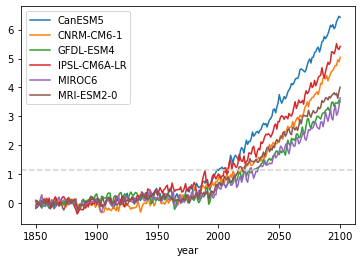

In [14]:
gmst_mod_all.columns = GCMs
gmst_mod_all.plot()
plt.axhline(warming_ar6_forster, ls='--', c='lightgray')
#plt.axhline(warming_sr15_forster, ls='--', c='gray')

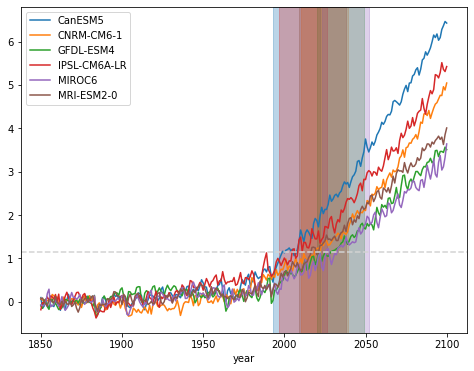

In [68]:
df_out_ar6 = pd.read_csv(os.path.join(out_path,'gmst_isimip3b_histrcp370_present-day-warming_ar6_Forster2023.csv'))
df_out_ar6

df_years = df_out_ar6[['model', 'year']]
df_years

# Set the color ramp
color = iter(cm.tab10(np.linspace(0, 1, 10))) #rainbow_r
color

# plot
fig,ax = plt.subplots(figsize=(8,6)) 
gmst_plot = gmst_mod_all.rolling(10, min_periods=1, center=False).mean()
gmst_plot = gmst_mod_all
gmst_plot.plot(ax=ax)
plt.axhline(warming_ar6_forster, ls='--', c='lightgray')

for i in range(len(df_years)): #  range(2): #
    c = next(color)
    y = ypos[i]
    ax.axvspan(df_years.iloc[i,1]-14, df_years.iloc[i,1]+15, alpha=0.3, color=c)


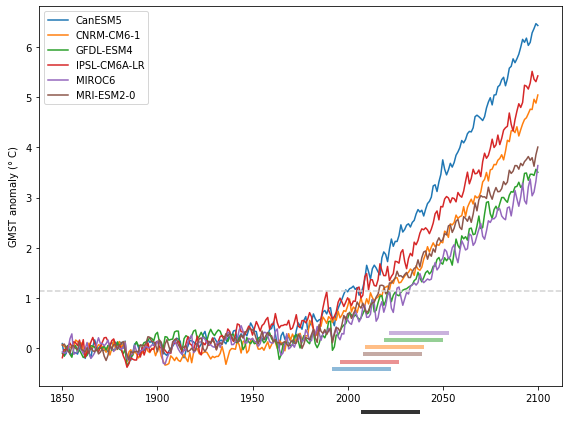

In [112]:
df_out_ar6 = pd.read_csv(os.path.join(out_path,'gmst_isimip3b_histrcp370_present-day-warming_ar6_Forster2023.csv'))
df_out_ar6

df_years = df_out_ar6[['model', 'year']]
df_years

# Set the color ramp
color = iter(cm.tab10(np.linspace(0, 1, 10))) #rainbow_r
color

# plot
fig,ax = plt.subplots(figsize=(8,6)) 
gmst_plot = gmst_mod_all.rolling(10, min_periods=1, center=False).mean()
gmst_plot = gmst_mod_all
gmst_plot.plot(ax=ax)
plt.axhline(warming_ar6_forster, ls='--', c='lightgray')
plt.legend()
plt.ylabel('GMST anomaly ($\degree$C)')
plt.xlabel(' ')

# set y positions
ypos = np.linspace(-.4, 0.3, 6)
indices = df_years.iloc[:,1].sort_values().index.values
ypos = [x for i, x in sorted(zip(indices, ypos))]

for i in range(len(df_years)): #  range(2): #
    c = next(color)
    y = ypos[i]
    #ax.axvspan(df_years.iloc[i,1]-14, df_years.iloc[i,1]+14, alpha=0.3, color=c)
    ax.plot([df_years.iloc[i,1]-14, df_years.iloc[i,1]+15] , #end, start
             [y, y], # year
             c=c,
             lw=4,
           alpha = 0.5)

trans = ax.get_xaxis_transform()
ax.plot([2022-14, 2022+15], # present-day 2022
        [0-0.07, 0-0.07],
        c='black',
        lw=4,  alpha=0.8,
        transform=trans, clip_on=False)    
    
fig.tight_layout()
#plt.savefig(os.path.join(fig_path,'isimip3b_warming_level_ar6_30yinterval_above_v2.png'),dpi=300)
#plt.savefig(os.path.join(fig_path,'isimip3b_warming_level_ar6_30yinterval_above_v2.pdf'),dpi=300)

# add annotation


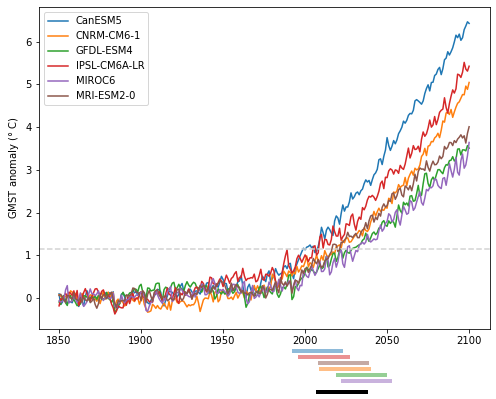

In [97]:
df_out_ar6 = pd.read_csv(os.path.join(out_path,'gmst_isimip3b_histrcp370_present-day-warming_ar6_Forster2023.csv'))
df_out_ar6

df_years = df_out_ar6[['model', 'year']]
df_years

# Set the color ramp
color = iter(cm.tab10(np.linspace(0, 1, 10))) #rainbow_r
color

# plot
fig,ax = plt.subplots(figsize=(7,5)) #8,6

#gmst_plot = gmst_mod_all.rolling(10, min_periods=1, center=False).mean()
gmst_plot = gmst_mod_all
#gmst_plot.plot(ax=ax)
ax.plot(gmst_plot, label=GCMs)
plt.axhline(warming_ar6_forster, ls='--', c='lightgray')
#plt.axvline(2022, ls='--', c='lightgray')
plt.legend()
plt.ylabel('GMST anomaly ($\degree$ C)')

# plot year intervals
trans = ax.get_xaxis_transform()
yposl = np.linspace(-.18, -.07, 7)
ypos = yposl[1:]
indices = df_years.iloc[:,1].sort_values(ascending=False).index.values
ypos = [x for i, x in sorted(zip(indices, ypos))]
#ypos = ypos.reverse()

for i in range(len(df_years)): #  range(2): #
    c = next(color)
    y = ypos[i]
    #ax.axvspan(df_years.iloc[i,1]-14, df_years.iloc[i,1]+14, alpha=0.3, color=c)
    ax.plot([df_years.iloc[i,1]-14, df_years.iloc[i,1]+15] , 
             [y, y], 
             c=c,
             lw=4,
           alpha = 0.5,
           transform=trans, clip_on=False)
ax.plot([2022-14, 2022+15],
        [y-0.09, y-0.09],
        c='black',
        lw=4,
        transform=trans, clip_on=False)

fig.tight_layout()
#plt.savefig(os.path.join(fig_path,'isimip3b_warming_level_ar6_30yinterval_v2.png'),dpi=300)
#plt.savefig(os.path.join(fig_path,'isimip3b_warming_level_ar6_30yinterval_v2.pdf'),dpi=300)

# figure out how to get this to not cut ! 

In [ ]:
# extensions: cfr with hist nat? or make these figures a little nicer, label the year intervals either with model names or year intervals - potentially with model names and get rid of legend